## Reading and Plotting NetCDF file

This notebook describes the process of reading a NetCDF file using callbacks to Python from geostack. When using callbacks to Python, we utilize `DataFileHandler` instead of `Raster` class.

For `DataFileHandler` to work, we need to use a predefined `DataHandler` e.g. `NC_Handler` for a NetCDF file or `GDAL_Handler` for GDAL based IO.

In [1]:
%matplotlib inline
import os
import os.path as pth
import sys
import numpy as np
from collections import OrderedDict
from datetime import datetime, timedelta
from time import time, sleep
import json
import tempfile
import warnings
# warnings.filterwarnings(action="ignore")

In [2]:
import matplotlib.pyplot as plt

Here, we import the necessary functionality from the `geostack` modules.

In [3]:
import geostack
from geostack.raster import (DataFileHandler, RasterCombinationType,
    RasterResolutionType)
from geostack.runner import runScript, getSolver
from geostack.core import ProjectionParameters

In [4]:
getSolver()

The NetCDF data is usually given in EPSG:4326 projection, so we instantiate an instance of `ProjectionParameters`.

In [5]:
projPROJ4_EPSG4326 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
proj_EPSG4326_REAL = ProjectionParameters.from_proj4(projPROJ4_EPSG4326)

Here, an example of how a `DataFileHandler` can be instantiated and then used to read a file. The two important **kwargs** for `DataFileHandler` are **file_handler** and **filePath**. 

Here **file_Handler** should be set to an instance of `DataHandler` and **filePath** should be either set to the path of file located on the disc or on an OPenDAP server.

In [6]:
file_path = pth.join(os.getcwd(), "data", "netcdf")

In [7]:
u10 = DataFileHandler(filePath=pth.join(file_path,
                    "IDY25006.APS3.wind.10m.2019121112.009.surface.nc4"),
                     backend="netcdf")

u10.read(thredds=False, use_pydap=False)
u10.setProperty("name", "u10")
u10.setProjectionParameters(proj_EPSG4326_REAL)

It is worth noting that when using `DataFileHandler`, we have called `setFileInputHandler` method, as that allows C++ objects to call python functions for reading the data from the file and populating underlying data object.

Similarly, we can intantiate another variable **v10**.

In [8]:
v10 = DataFileHandler(filePath=pth.join(file_path,
                    "IDY25006.APS3.wind.10m.2019121112.009.surface.nc4"),
                     backend="netcdf")

v10.read(thredds=False, use_pydap=False)
v10.setProperty("name", "v10")
v10.setProjectionParameters(proj_EPSG4326_REAL)

Now, we can plot the two variables i.e. **u10** and **v10** instantiated using `DataFileHandler` object.

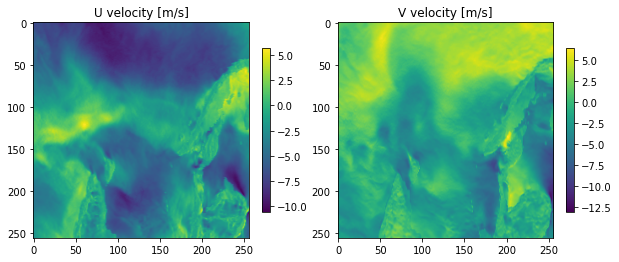

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax = axs.ravel()
cs = ax[0].imshow(np.ma.masked_invalid(u10.getData(0, 0)))
ax[0].set_title("U velocity [m/s]")
fig.colorbar(cs, ax=ax[0], shrink=0.6, fraction=0.1)
cs = ax[1].imshow(np.ma.masked_invalid(v10.getData(0, 0)))
ax[1].set_title("V velocity [m/s]");
fig.colorbar(cs, ax=ax[1], shrink=0.6, fraction=0.1)

To perform computation using the variables instantiated above, we will create a list of rasters. 

For this purpose, there are two different objects defined in `raster` module. The two objects are `RasterBaseList` and `RasterPtrList`, where the former is a *std::vector* of `RasterBase` object while the latter is a *std::vector* of *std::shared_ptr* of `Raster`.

To make is similar to python, convenience method `append` has been provided with both `RasterBaseList` and `RasterPtrList` objects.

In [10]:
# raster_list = RasterBaseList(dtype=np.float32)
# for item in [u10, v10]:
#     raster_list.append(item)

Once, we have created a list of rasters, we can write a script to compute mean wind speed using the wind vectors **u10** and **v10**.

\begin{equation*}
\overline{U} = (u_{10}^2 + v_{10}^2)^{1/2}
\end{equation*}

In [11]:
script = "output = sqrt(u10 * u10 + v10 * v10);"
wind_speed = runScript(script, [u10, v10],
                       parameter=RasterCombinationType.Intersection,
                      output_type=np.float32)
wind_speed.setProperty("name", "windSpeed")

Similarly, wind direction can be simply written as

\begin{equation*}
   \textit{wdir} = \arctan2(\frac{v_{10}}{u_{10}}) * \frac{180}{\pi}
\end{equation*}

In [12]:
script = "output = atan2(v10, u10) * (180.0 / M_PI);"
wind_direction = runScript(script, [u10, v10],
                       parameter=RasterCombinationType.Intersection,
                      output_type=np.float32)
wind_direction.setProperty("name", "windDirection")

Now, we can plot the mean wind speed and wind direction to visualize the results.

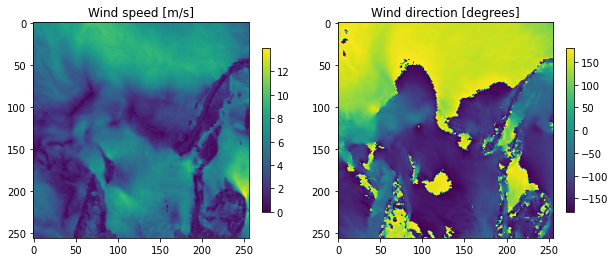

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax = axs.ravel()
cs = ax[0].imshow(np.ma.masked_invalid(wind_speed.writeData(0, 0)))
ax[0].set_title("Wind speed [m/s]")
fig.colorbar(cs, ax=ax[0], shrink=0.6, fraction=0.1)
cs = ax[1].imshow(np.ma.masked_invalid(wind_direction.writeData(0, 0)))
ax[1].set_title("Wind direction [degrees]");
fig.colorbar(cs, ax=ax[1], shrink=0.6, fraction=0.1)